# Quality Control: Strand and mapping correction, anchoring and

population covariates

> **Important notes for this notebook**
>
> In this section, we will explore how to match strands and reference
> mapping to merge HapMap and 1000GP data. Then we will use population
> information from one dataset to decide if there are ethnic outliers in
> the other. Finally we generate population covariates useful for
> association testing. \## Learning outcomes
>
> -   **Evaluate** when and how to apply strand and mapping correction
> -   **Discuss** confounding factors that lead to spurious associations
> -   **Identify** population substructure and filter out outliers
> -   **Correct** for population stratification
>
> ## How to make this notebook work
>
> In this notebook, we will both use `R` and `bash command line`
> programming languages. Remember to **change the kernel** whenever you
> transition from one language to the other (`Kernel --> Change Kernel`)
> indicated by the languages’ images. \* We will first run `Bash`
> commands.
>
> <img src="Images/bash.png" alt="Bash" width="80"> Choose the Bash
> kernel

# Merging, anchoring and making covariates

Population stratification presents a significant source of systematic
bias in GWAS, arising **when subpopulations exhibit systematic
differences in allele frequencies**. Research indicates that even subtle
degrees of population stratification can exist within a single ethnic
population (Abdellaoui et al. 2013). Thus, testing and controlling for
the presence of population stratification is an essential QC step.

The population structure (or in other words, the ancestral relationship
of the populations) is a so-called **confounding factor**. This means
that it affects both the dependent and independent variables, as shown
in the figure below, where both the genotype and traits are influenced
by population structure (e.g., the distribution of north and south
European individuals in the PCA space and the height of those
individuals).

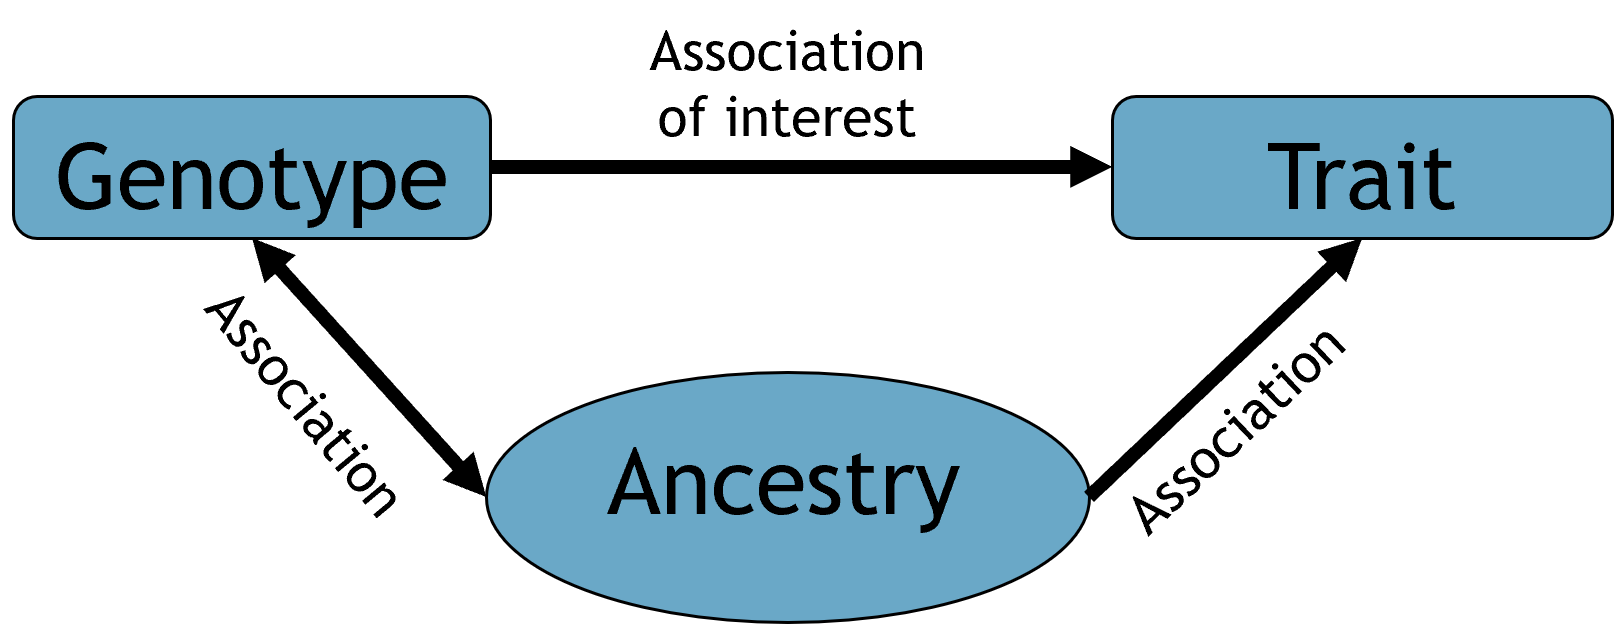

Why is a bias introduced? Population structure can influence allele
frequencies and produce false positives/negatives when doing association
testing. Graphically, consider the example in the figure below. Case and
control for population 1 and 2 have specific MAFs. Removing the barrier
between populations will change MAFs drastically for the two confitions.

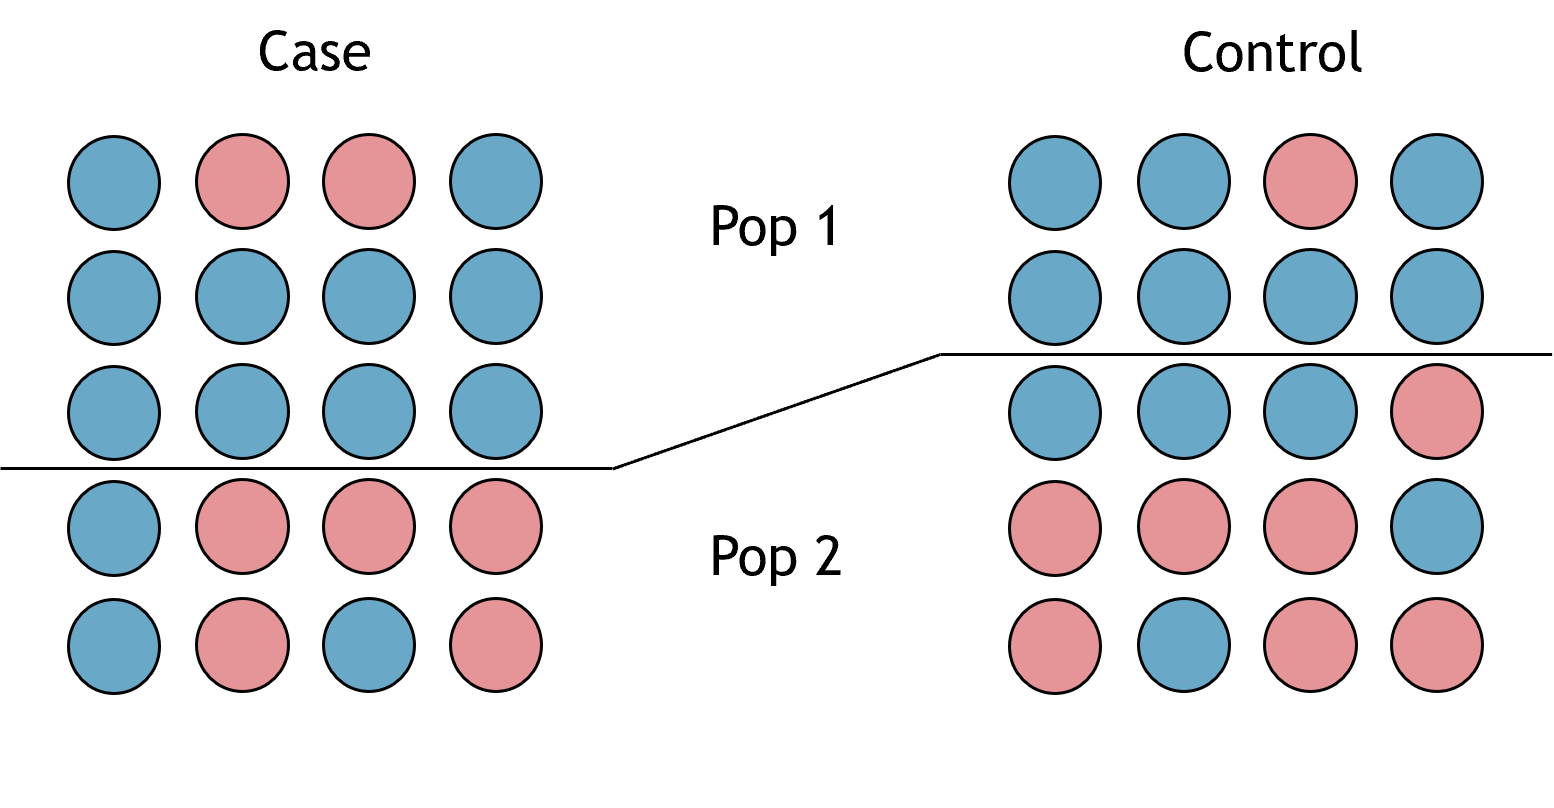

The same problem arises in population studies without Case-control
categories. Imagine having a population of randomly sampled individuals,
each from a different ethnicity (the blue and red minor alleles in the
example below). The final group of individuals will have a different
proportion of MAFs depending on the sampling of various ethnicities.

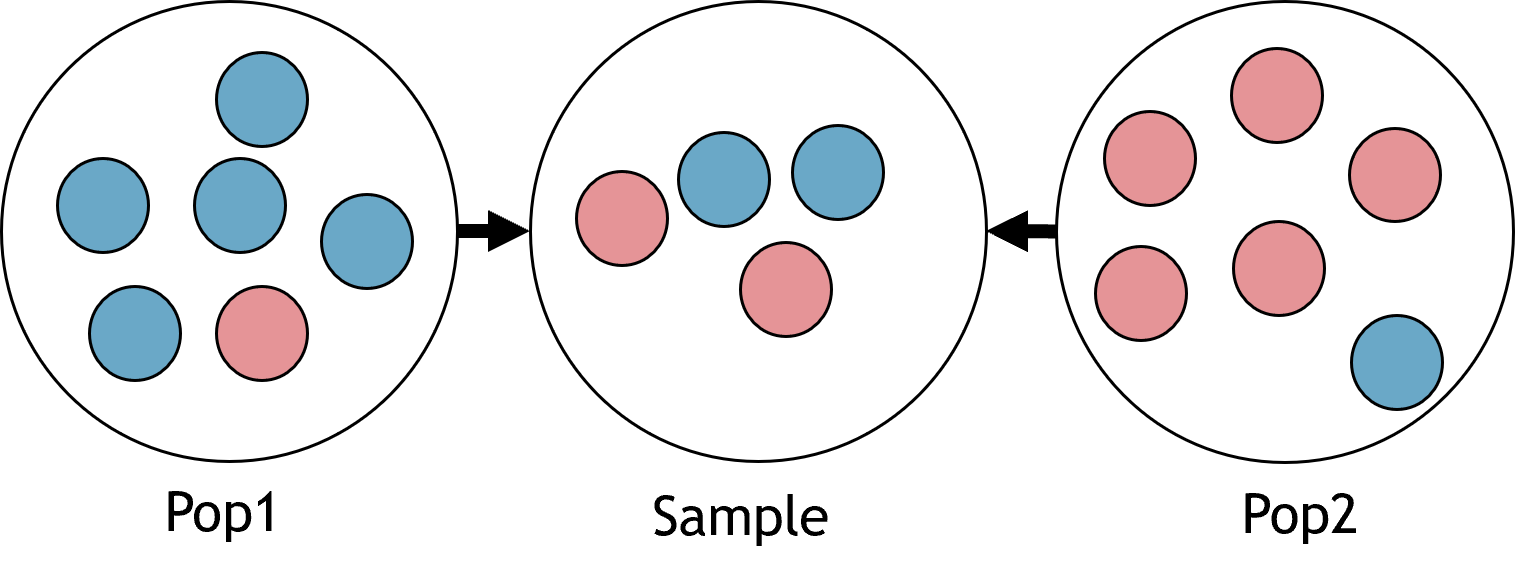

There are several methods to correct for population stratification Alkes
L. Price et al. (2006). Here, we illustrate a method integrated into
PLINK: the **multidimensional scaling (MDS)** approach. MDS calculates
the genome-wide average proportion of shared alleles between any pair of
individuals to generate quantitative indices (components) of the genetic
variation for each individual. **The individual component scores can be
visualized to identify groups of genetically similar individuals.** For
instance, in a genetic study including subjects from Asia and Europe,
MDS analysis would reveal that Asians are genetically more similar to
each other than to Europeans and Africans. The figure below shows
another example of MDS using HapMap, Genome diversity project, and
authors’ data:

<figure>
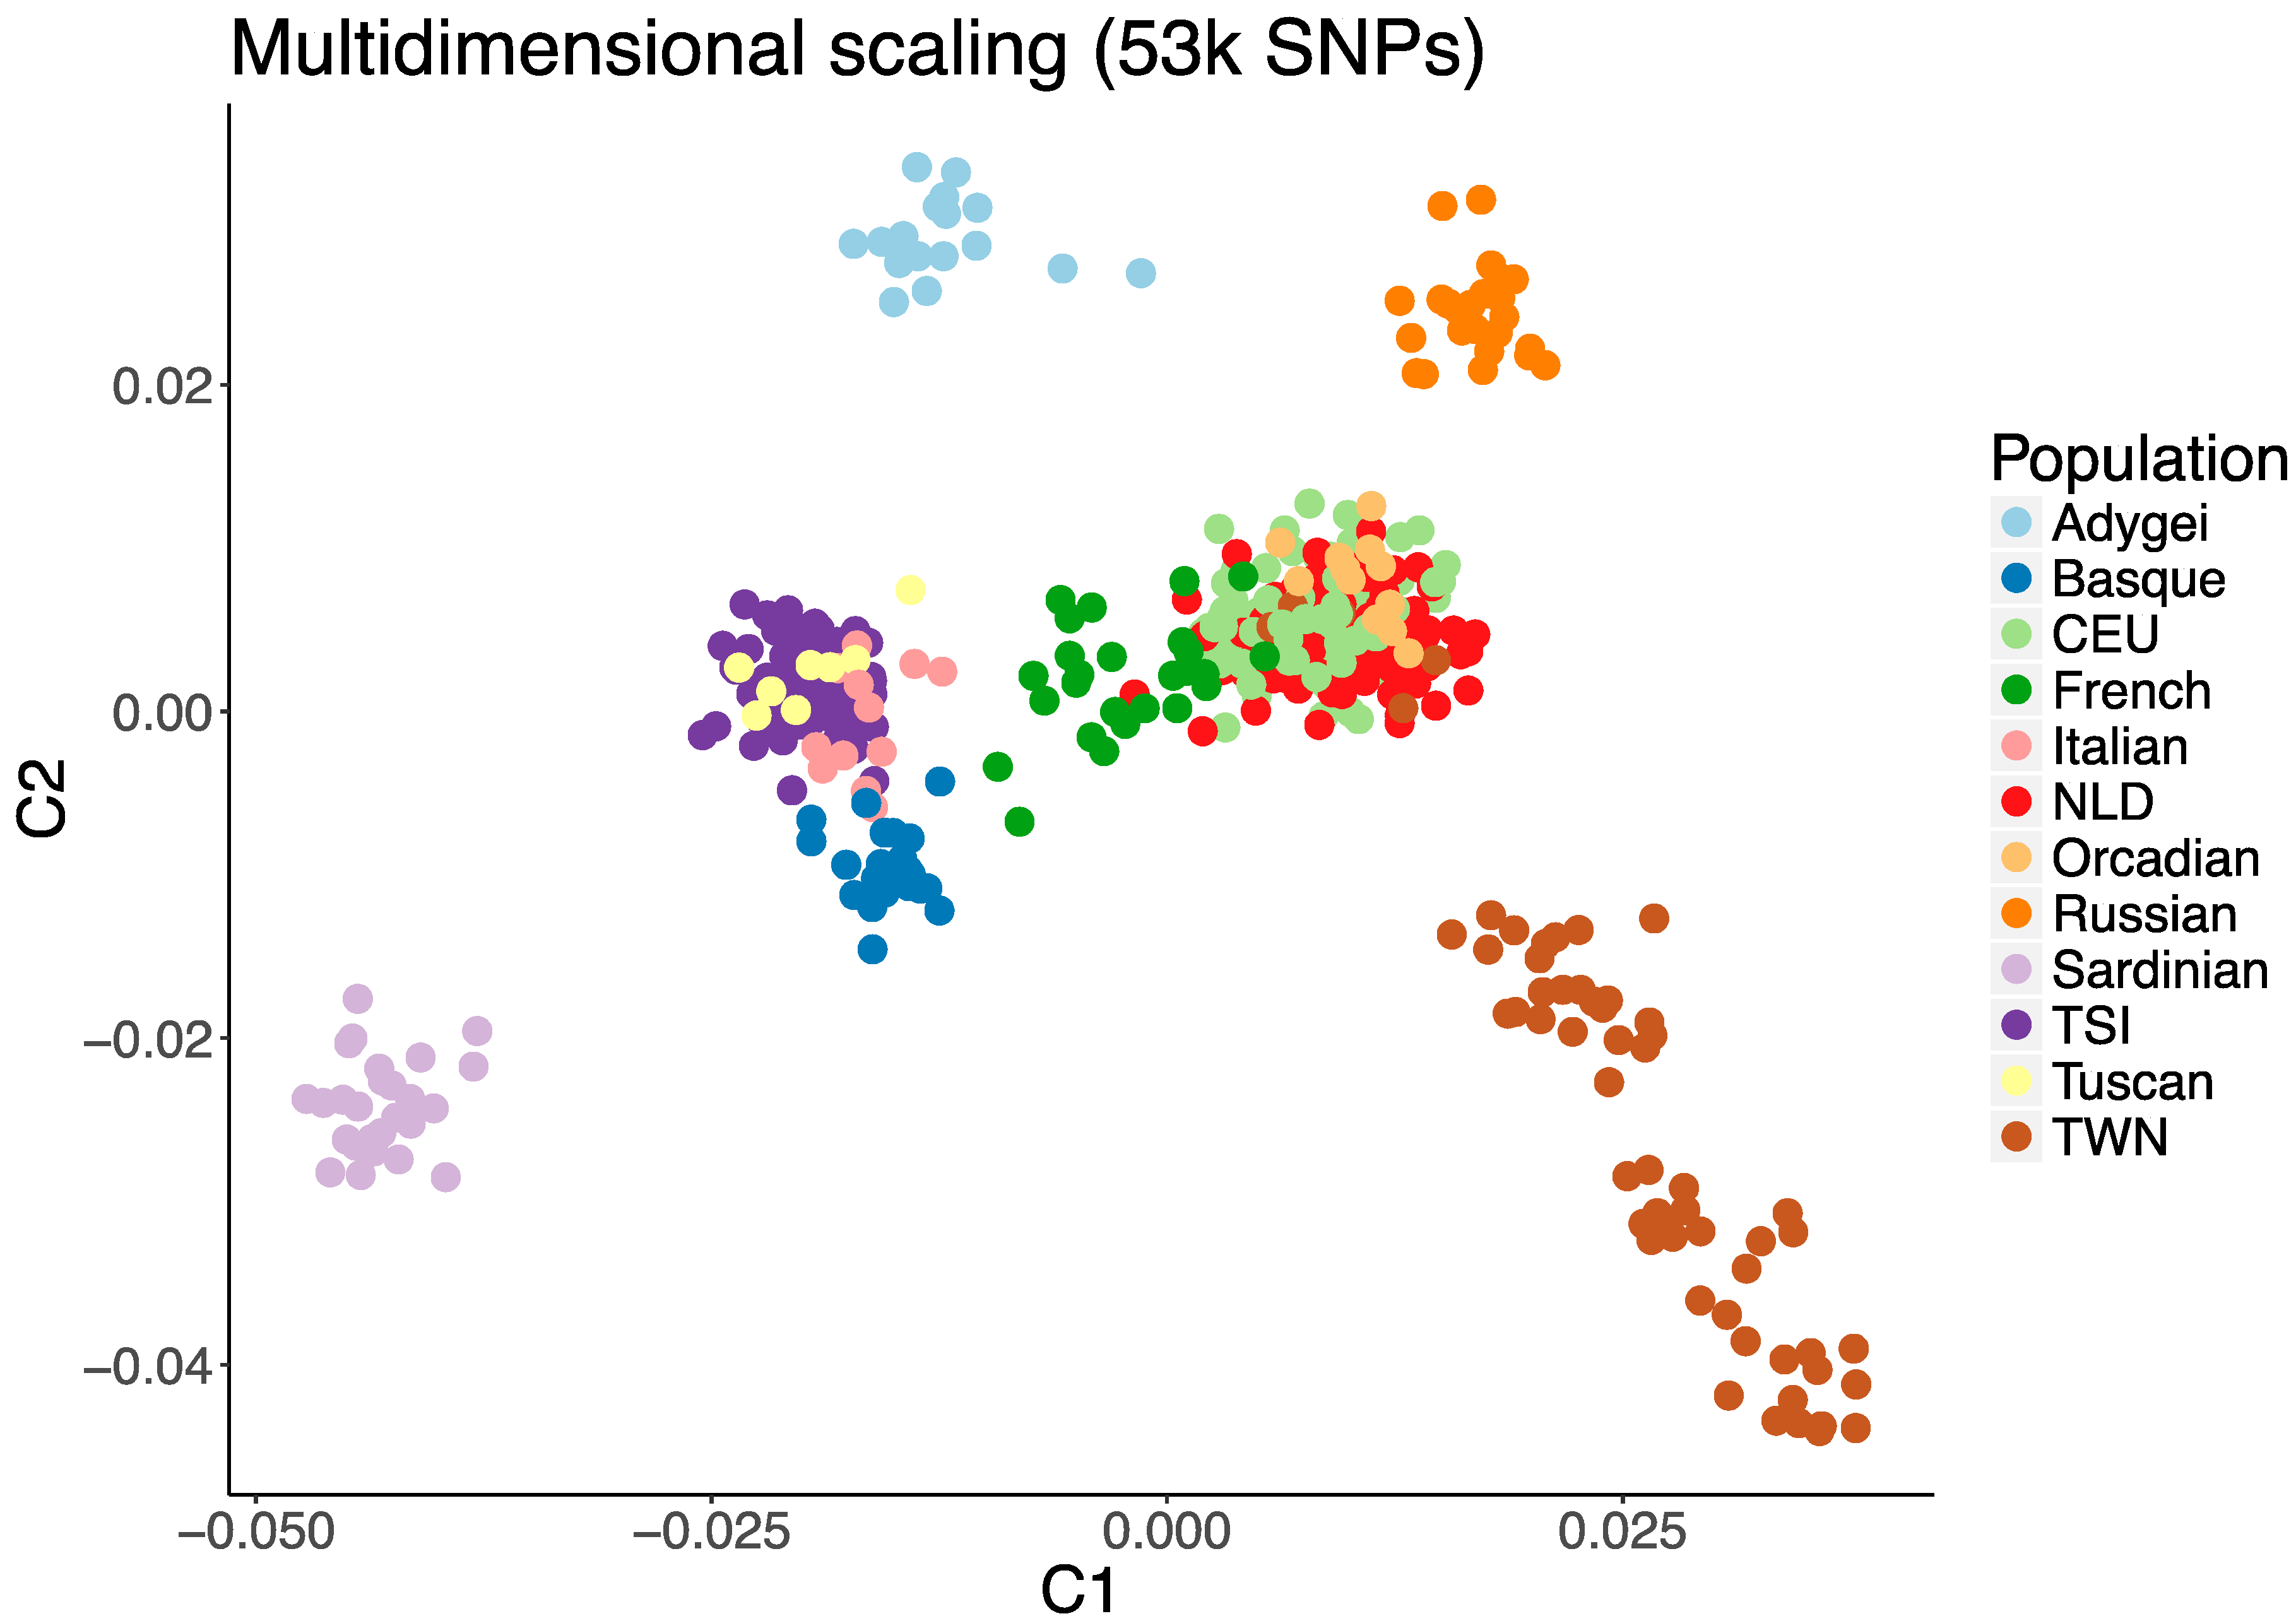
<figcaption aria-hidden="true">Example of MDS plot of the first two MDS
components scores on integrated datasets in <span class="citation"
data-cites="somers_genetic_2017">Somers et al. (2017)</span>. Here TWN,
a past isolated population in the Netherlands, is separated from the
other individuals from the same country (NDL). Sardinians, notoriously
different from continental Italians, are also grouped far away from
them. Central European populations colocalize as expected.</figcaption>
</figure>

## Anchoring

To investigate which individuals the generated component scores deviate
from in the target population, plotting the scores of the dataset under
investigation and a population of known ethnic structure (e.g.,
HapMap/1KG data) is helpful: this step is called **anchoring** (Rietveld
et al. 2013). This enables the researcher to obtain ethnic information
on their data and to determine possible ethnic outliers. For example, in
the figure above, if TSI (Tuscans from Italy) is the anchor population,
one can hypothesize that the yellow dots might be ethnically similar (as
in the example).

## Outlier removal

Outliers identified based on MDS analysis should be excluded from
further analyses. Following their removal, a new MDS analysis must be
conducted, and its primary components are utilized as covariates in
association tests to correct for any residual population stratification
within the population. The number of components to include depends on
the population structure and sample size (usually 10-20).

The MDS from Cortellari et al. (2021) shows a distinct goat population
outlier. The second axis is dominated by this outlier, obscuring
structure in the other populations. Removing the outlier reveals a
clearer structure among the remaining populations.

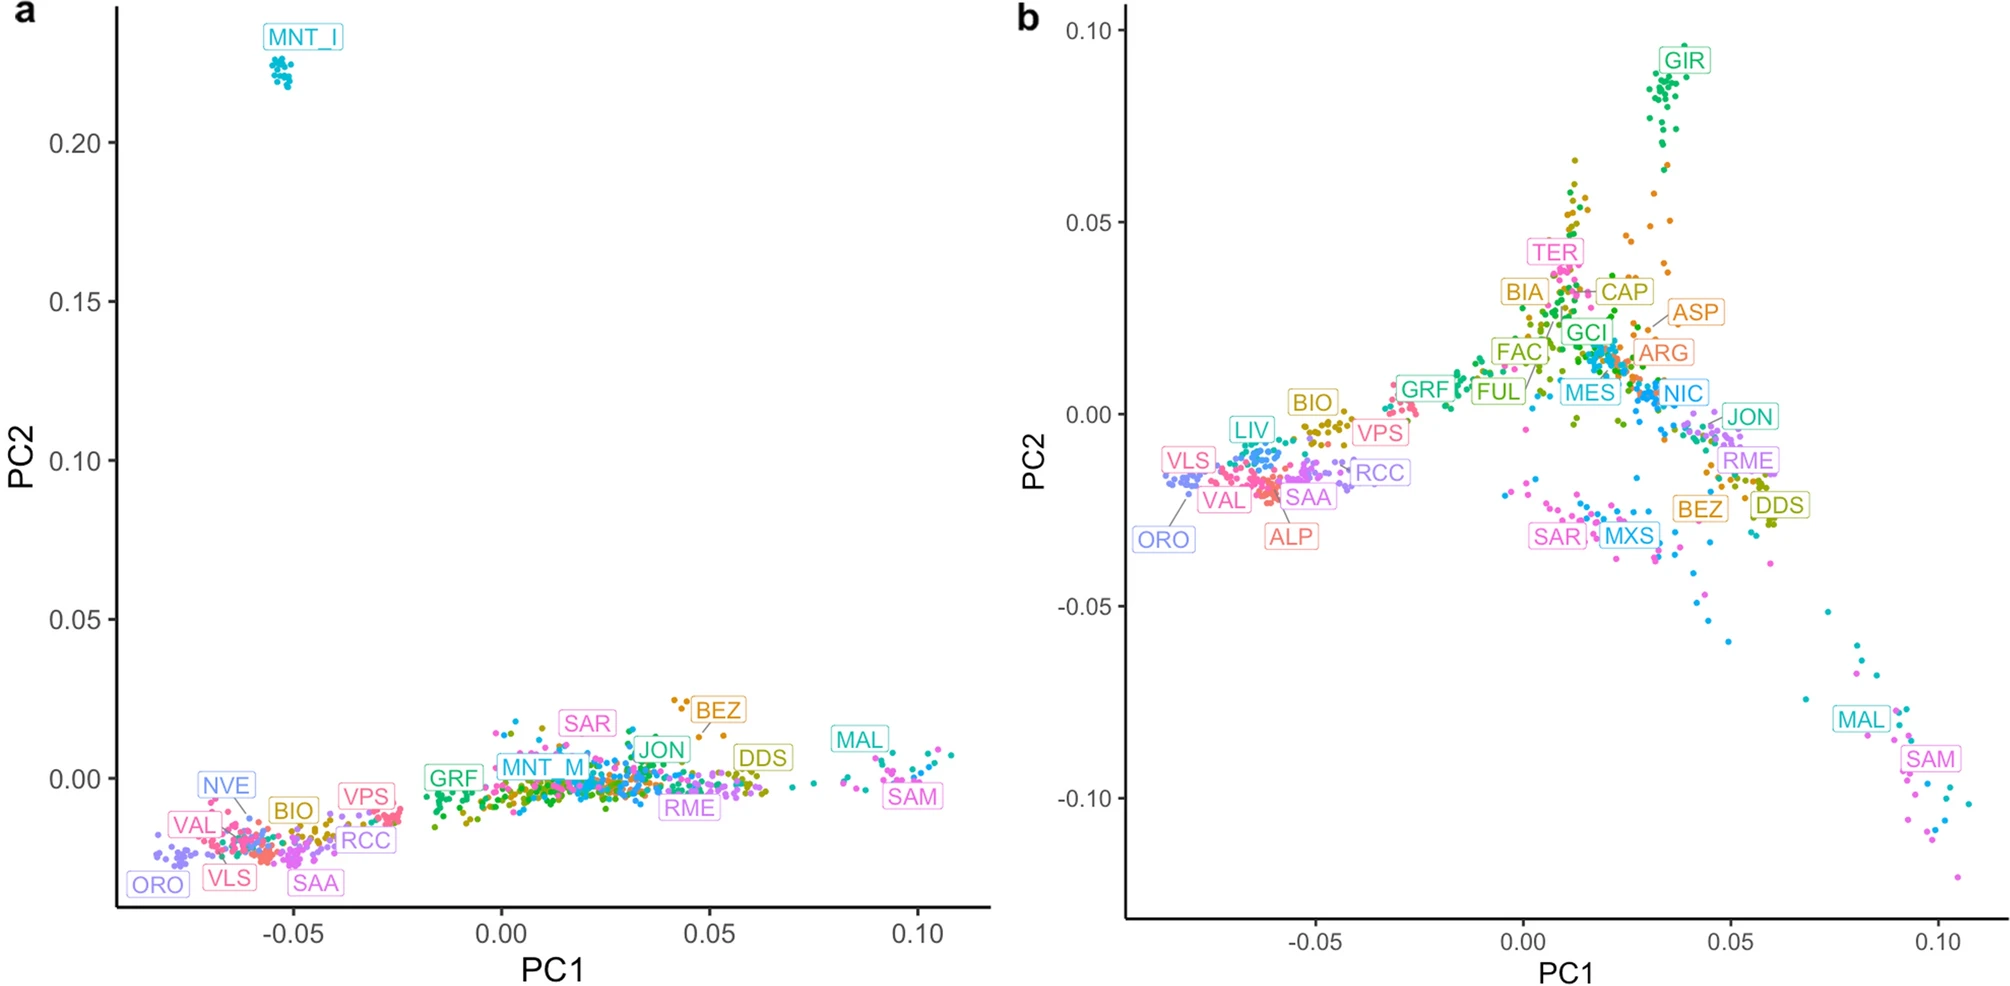

# Analysis

We aim to merge the HapMap and 1000GP datasets, using 1000GP Phase I as
the anchor for HapMap. Our goal is to check if we can identify the
ethnicity of the HapMap data based on the ethnicities in the 1000GP
dataset. There are several steps to ensure compatibility between the
datasets, so stay with us!

## 1000GP data download

Here are some commands to download and convert the 1000GP data for GWAS
analysis. **You don’t need to run them**, as we’ve already processed the
data.

-   1000 Genomes Project - Phase I: genetic information for 629
    individuals from various ethnic groups (\>60GB). *Phase III is now
    available, and we recommend using it for research purposes.*

``` bash
wget ftp://ftp-trace.ncbi.nih.gov/1000genomes/ftp/release/20100804/ALL.2of4intersection.20100804.genotypes.vcf.gz
```

The data was converted from the `vcf` file (Variant Call Format) to
plink format (`bim`, `fam`, `bed`):

``` bash
plink2 --vcf ALL.2of4intersection.20100804.genotypes.vcf.gz --make-bed --out ALL.2of4intersection.20100804.genotypes
```

> **Note**
>
> The 1000 Genomes data downloaded above is rather large so the commands
> are not executable and are shown for reference only. To save time,
> we’ve provided the `.bed`, `.bim`and `.fam` files in the `Data`
> folder.

Let’s unzip the files and see how many samples we have.

In [6]:
unzip -o Data/1000genomes.zip -d Results/GWAS4
# count lines in fam 
wc -l Results/GWAS4/1000genomes.genotypesA.fam

Archive:  Data/1000genomes.zip
  inflating: Results/GWAS4/1000genomes.genotypesA.bed  
  inflating: Results/GWAS4/1000genomes.genotypesA.bim  
  inflating: Results/GWAS4/1000genomes.genotypesA.fam  
  inflating: Results/GWAS4/1000genomes.genotypesA.log  
  inflating: Results/GWAS4/1000genomes.genotypesA.nosex  
37 Results/GWAS4/1000genomes.genotypesA.fam

We have a subset of **37 individuals**. Now, let’s explore the `bim`
file.

In [7]:
cat Results/GWAS4/1000genomes.genotypesA.bim | head -5

1   rs112750067 0   10327   C   T
1   .   0   11508   A   G
1   .   0   12783   G   A
1   .   0   13116   G   T
1   .   0   14933   A   G

One should note that the file `1000genomes.genotypes.bim` contains SNPs
without an rs-identifier (or Reference SNP cluster ID). The missing
rs-identifiers (noted as `.`) are not a problem for this tutorial.
However, for good practice, we will assign unique identifiers to the
SNPs (using available information):

In [8]:
plink --bfile Results/GWAS4/1000genomes.genotypesA \
    --set-missing-var-ids @:#[b37]\$1,\$2 \
    --make-bed \
    --out Results/GWAS4/1000genomes.genotypesA_no_missing_IDs \
    --silent

Now, let’s visualize the data to check the SNP names assigned. These are
derived from the format `@:#[b37]\$1,\$2` in the command above, which
PLINK interprets as `chromosome:locus[b37]Allele1,Allele2`:

In [9]:
# Show changes on the bim file
cat Results/GWAS4/1000genomes.genotypesA_no_missing_IDs.bim | head -5

1   rs112750067 0   10327   C   T
1   1:11508[b37]A,G 0   11508   A   G
1   1:12783[b37]A,G 0   12783   G   A
1   1:13116[b37]G,T 0   13116   G   T
1   1:14933[b37]A,G 0   14933   A   G

Pretty neat, right?

## QC on 1000GP data

As we covered in the GWAS3 notebook, it’s important to account for
missingness, sex discrepancies, and minor allele frequency. We’ll apply
standard QC thresholds to the 1000 GP data before merging it with HapMap
data.

In [10]:
plink --bfile Results/GWAS4/1000genomes.genotypesA_no_missing_IDs \
    --geno 0.02 \
    --make-bed \
    --out Results/GWAS4/1kG_MDS --silent

plink --bfile Results/GWAS4/1kG_MDS \
    --mind 0.02 \
    --make-bed \
    --out Results/GWAS4/1kG_MDS2 --silent
    
plink --bfile Results/GWAS4/1kG_MDS2 \
    --maf 0.05 \
    --make-bed  \
    --out Results/GWAS4/1kG_MDS3 --silent

## SNPs matching between datasets

N.B: Ensure that the datasets you want to merge share the same genomic
build! Otherwise, you’ll need to include a liftover step.

We want to only consider SNPs that both datasets have in common. First,
extract SNP names from the HapMap data and filter the 1000GP data to
include only matching SNPs.

In [11]:
#Print out SNPs from the HapMap data
awk '{print$2}' Results/GWAS4/HapMap_3_r3_9.bim > Results/GWAS4/HapMap_SNPs.txt

#Extract the HapMap SNPs from the 1000GP data
plink --bfile Results/GWAS4/1kG_MDS3 \
    --extract Results/GWAS4/HapMap_SNPs.txt \
    --make-bed \
    --out Results/GWAS4/1kG_MDS4

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS4/1kG_MDS4.log.
Options in effect:
  --bfile Results/GWAS4/1kG_MDS3
  --extract Results/GWAS4/HapMap_SNPs.txt
  --make-bed
  --out Results/GWAS4/1kG_MDS4

385567 MB RAM detected; reserving 192783 MB for main workspace.
2232052 variants loaded from .bim file.
37 people (0 males, 0 females, 37 ambiguous) loaded from .fam.
Ambiguous sex IDs written to Results/GWAS4/1kG_MDS4.nosex .
--extract: 376380 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 37 founders and 0 nonfounders present.
Calculating allele frequencies... done.
376380 variants and 37 people pass filters and QC.
Note: No phenotypes present.
--make-bed to Results/GWAS4/1kG_MDS4.bed + Results/GWAS4/1kG_MDS4.bim +
Results/GWAS4/1kG_MDS4.fam ... done.

This is how part of the list of SNP names looks like:

In [12]:
cat Results/GWAS4/HapMap_SNPs.txt | head -5

rs3131972
rs3131969
rs1048488
rs12562034
rs12124819

Now we take the variants from the reduced 1000GP data, and go the other
way around. We extract 1000GP variants from the HapMap data. In other
words, the two extraction passages will intersect the SNPs. Below is the
code to use the SNPs of the 1000GP data to reduce the HapMap data.

In [13]:
#Print out SNPs from the HapMap data
awk '{print$2}' Results/GWAS4/1kG_MDS4.bim > Results/GWAS4/1kG_MDS4_SNPs.txt

#Extract the HapMap SNPs from the 1000GP data
plink --bfile Results/GWAS4/HapMap_3_r3_9 \
    --extract Results/GWAS4/1kG_MDS4_SNPs.txt \
    --make-bed \
    --out Results/GWAS4/HapMap_MDS

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS4/HapMap_MDS.log.
Options in effect:
  --bfile Results/GWAS4/HapMap_3_r3_9
  --extract Results/GWAS4/1kG_MDS4_SNPs.txt
  --make-bed
  --out Results/GWAS4/HapMap_MDS

385567 MB RAM detected; reserving 192783 MB for main workspace.
1073226 variants loaded from .bim file.
109 people (55 males, 54 females) loaded from .fam.
109 phenotype values loaded from .fam.
--extract: 376380 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 109 founders and 0 nonfounders present.
Calculating allele frequencies... done.
Total genotyping rate is 0.998025.
376380 variants and 109 people pass filters and QC.
Among remaining phenotypes, 54 are cases and 55 are controls.
--make-bed to Results/GWAS4/HapMap_MDS.bed + Results/GWAS4/HapMap_MDS.bim +
Results/GWAS4/HapMap_MDS.fam .

> **Stop - Read - Solve**
>
> **Look at the two outputs below a bit more carefully. The names are
> all matching. Is there any other problem?**

In [14]:
head Results/GWAS4/HapMap_MDS.bim

1   rs3131969   0   744045  A   G
1   rs12562034  0   758311  A   G
1   rs4970383   0   828418  A   C
1   rs4475691   0   836671  T   C
1   rs1806509   0   843817  C   A
1   rs28576697  0   860508  C   T
1   rs3748595   0   877423  A   C
1   rs13303118  0   908247  G   T
1   rs1891910   0   922320  A   G
1   rs3128097   0   970323  G   A

In [15]:
head Results/GWAS4/1kG_MDS4.bim

1   rs3131969   0   754182  A   G
1   rs12562034  0   768448  A   G
1   rs4970383   0   838555  A   C
1   rs4475691   0   846808  T   C
1   rs1806509   0   853954  A   C
1   rs28576697  0   870645  C   T
1   rs3748595   0   887560  A   C
1   rs13303118  0   918384  T   G
1   rs1891910   0   932457  A   G
1   rs3128097   0   980460  G   A

## Build matching

Genomic data is based on a reference genome, and our datasets use
different human reference versions. Since the reference genome improves
over time, SNP positions may differ between datasets from different
versions.

We extract SNP names and positions from the HapMap data and align the
1000GP data to match these SNPs using the `--update-map` option in
PLINK.

In [16]:
#Extract the HapMap variant coordinates
awk '{print$2,$4}' Results/GWAS4/HapMap_MDS.bim > Results/GWAS4/buildhapmap.txt

This is how the list of SNPs look like:

In [17]:
cat Results/GWAS4/buildhapmap.txt | head -5

rs3131969 744045
rs12562034 758311
rs4970383 828418
rs4475691 836671
rs1806509 843817

We run PLINK to update the 1000GP variant coordinates based on HapMap,
ignoring the warning about unsorted positions:

In [18]:
plink --bfile Results/GWAS4/1kG_MDS4 \
    --update-map Results/GWAS4/buildhapmap.txt \
    --make-bed \
    --out Results/GWAS4/1kG_MDS5

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS4/1kG_MDS5.log.
Options in effect:
  --bfile Results/GWAS4/1kG_MDS4
  --make-bed
  --out Results/GWAS4/1kG_MDS5
  --update-map Results/GWAS4/buildhapmap.txt

385567 MB RAM detected; reserving 192783 MB for main workspace.
376380 variants loaded from .bim file.
37 people (0 males, 0 females, 37 ambiguous) loaded from .fam.
Ambiguous sex IDs written to Results/GWAS4/1kG_MDS5.nosex .
--update-map: 376380 values updated.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 37 founders and 0 nonfounders present.
Calculating allele frequencies... done.
376380 variants and 37 people pass filters and QC.
Note: No phenotypes present.
--make-bed to Results/GWAS4/1kG_MDS5.bed + Results/GWAS4/1kG_MDS5.bim +
Results/GWAS4/1kG_MDS5.fam ... done.

## Merging datasets and performing MDS

Before merging the HapMap and 1000 Genomes datasets, we ensure
compatibility through 3 steps:

1.  Verify the reference genome is compatible in both datasets.
2.  Align SNP orientations (strand) across datasets.
3.  Remove SNPs that still differ after these steps.

The next steps are technical but ensure the datasets correspond
correctly.

**1.** We’ve matched SNP positions, but we also need to ensure the
reference alleles align. Remember that most PLINK analyses **consider
the A1 allele (typically the minor allele) as the reference allele**,
which is logical when dealing exclusively with biallelic variants.

Below, we generate a list of SNPs ID and ‘reference alleles’
(corresponding to A1, column 5 of the `.bim` file) from 1000GP.

In [19]:
#Extract variant coordinates and reference alleles from 1000GP data
awk '{print$2,$5}' Results/GWAS4/1kG_MDS5.bim > Results/GWAS4/1kg_ref-list.txt

How the list looks like:

In [20]:
head -5 Results/GWAS4/1kg_ref-list.txt

rs3131969 A
rs12562034 A
rs4970383 A
rs4475691 T
rs1806509 A

Then, we assign them to the HapMap data `--ref-allele` option. Note a
lot fo warnings in A1 allele assignment. This is usually because you
have a strand issue, where the data uses a complement

In [21]:
plink --bfile Results/GWAS4/HapMap_MDS  \
    --make-bed \
    --reference-allele Results/GWAS4/1kg_ref-list.txt  \
    --out Results/GWAS4/HapMap-adj 

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS4/HapMap-adj.log.
Options in effect:
  --a1-allele Results/GWAS4/1kg_ref-list.txt
  --bfile Results/GWAS4/HapMap_MDS
  --make-bed
  --out Results/GWAS4/HapMap-adj

385567 MB RAM detected; reserving 192783 MB for main workspace.
376380 variants loaded from .bim file.
109 people (55 males, 54 females) loaded from .fam.
109 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 109 founders and 0 nonfounders present.
Calculating allele frequencies... done.
Total genotyping rate is 0.998025.
--a1-allele: 376380 assignments made.
376380 variants and 109 people pass filters and QC.
Among remaining phenotypes, 54 are cases and 55 are controls.
--make-bed to Results/GWAS4/HapMap-adj.bed + Results/GWAS4/HapMap-adj.bim +
Results/GWAS4/HapMap-adj.fam ... 

**2.** To resolve strand issues, we flip SNPs found in both datasets
with complementary alleles (i.e. they were reported in opposite
strands). We generate SNP lists (ID and alleles) for both datasets,
identify unique SNPs, and visualize differences in allele reporting. If
a SNP is unique but reports alleles differently, it will appear twice.
Below are examples of SNPs with strand issues from the 1000GP and HapMap
data:

In [1]:
#print SNP and A1 A2 alleles on files for the two datasets
awk '{print$2,$5,$6}' Results/GWAS4/1kG_MDS5.bim > Results/GWAS4/1kGMDS5_tmp
awk '{print$2,$5,$6}' Results/GWAS4/HapMap-adj.bim > Results/GWAS4/HapMap-adj_tmp

#sort by SNP name to see SNPs with complementary alleles
sort Results/GWAS4/1kGMDS5_tmp Results/GWAS4/HapMap-adj_tmp | uniq -u > Results/GWAS4/all_differences.txt

In [2]:
head -6 Results/GWAS4/all_differences.txt

rs10006274 C T
rs10006274 G A
rs1008660 A G
rs1008660 T C
rs10088098 C T
rs10088098 G A

**How many of these differences are there?** We can count 604 lines, so
302 SNPs

In [3]:
wc -l Results/GWAS4/all_differences.txt

604 Results/GWAS4/all_differences.txt

Some of these differences might be might be due to strand issues.

Let’s look at this variant `rs10006274`. **Will it be flipped in the
HapMap dataset?**

The answer is yes! If we look at the reference allele in
`1kg_ref-list.txt`, it shows `C`. This means the SNP is on the forward
strand in 1000GP (C/T) and on the reverse strand in HapMap (G/A).

In [4]:
grep rs10006274 Results/GWAS4/1kg_ref-list.txt

In [5]:
grep rs10006274 Results/GWAS4/all_differences.txt

> **Stop - Read - Solve**
>
> Look at these other SNPs: `rs9614750` and `rs10088098`.
>
> -   **Which ones will have to be flipped?**
> -   **Is it always the same dataset that must be flipped?**

In [ ]:
# Write your code here 

> **Solution**
>
> We will first print out the SNPs from the reference file to know which
> line corresponds to each dataset (since we know we used the 1000
> Genomes Project as the reference). If there are strand issues, the SNP
> will need to be flipped in the dataset that wasn’t used as the
> reference.
>
> ``` bash
> grep rs9614750 Results/GWAS4/1kg_ref-list.txt 
> ```
>
> <pre><span class="ansi-red-fg ansi-bold">rs9614750</span> A
> </pre>
>
> ``` bash
> grep rs9614750 Results/GWAS4/all_differences.txt
> ```
>
> <pre><span class="ansi-red-fg ansi-bold">rs9614750</span> A G
>
> <span class="ansi-red-fg ansi-bold">rs9614750</span> C G
> </pre>
>
> For `rs9614750`, the genotype is reported as `A/G` in the 1000GP data,
> while in HapMap, it is `C/G`. This discrepancy between the two
> datasets means that the SNP will need to be removed later.
>
> ``` bash
> grep rs10088098 Results/GWAS4/1kg_ref-list.txt 
> ```
>
> <pre><span class="ansi-red-fg ansi-bold">rs10088098</span> C
> </pre>
>
> ``` bash
> grep rs10088098 Results/GWAS4/all_differences.txt
> ```
>
> <pre><span class="ansi-red-fg ansi-bold">rs10088098</span> C T
>
> <span class="ansi-red-fg ansi-bold">rs10088098</span> G A
> </pre>
>
> For `rs10088098`, the genotype is reported as `C/T` in the 1000GP
> data, while in HapMap, it is `G/A`. This means that PLINK will flip
> the allele, as they are complementary.

------------------------------------------------------------------------

Now we take only the SNP names and give them to PLINK (option `--flip`),
together with the reference genome (option `--reference-allele`):

In [10]:
## Flip SNPs for resolving strand issues.
# Print SNP-identifier and remove duplicates.
awk '{print$1}' Results/GWAS4/all_differences.txt | sort -u > Results/GWAS4/flip_list.txt

In [11]:
wc -l Results/GWAS4/flip_list.txt

302 Results/GWAS4/flip_list.txt

These are the SNP ID of non-corresponding SNPs (N=302) between the two
files.

In [12]:
head -5 Results/GWAS4/flip_list.txt

rs10006274
rs1008660
rs10088098
rs1011297
rs1023098

Apply the flipping option:

In [13]:
plink --bfile Results/GWAS4/HapMap-adj \
    --flip Results/GWAS4/flip_list.txt \
    --reference-allele Results/GWAS4/1kg_ref-list.txt \
    --make-bed \
    --out Results/GWAS4/corrected_hapmap \
    --silent

> **Stop - Read - Solve**
>
> There might still be problematic SNPs after flipping.
>
> -   **Check if the expected allele flip occurred.**
>
> Hint: use `grep` to find the `rs10006274` and `rs9614750` variants;
> then compare the alleles assignments in the HapMap file before and
> after flipping.

In [ ]:
# Write your code here 

> **Solution**
>
> PLINK attempts to flip all SNPs in the list, but an error occurs when
> A1 does not match the one in the reference.
>
> Notice how this SNP has changed as we predicted:
>
> ``` bash
> grep rs10006274 Results/GWAS4/corrected_hapmap.bim
> ```
>
> <pre>4  <span class="ansi-red-fg ansi-bold">rs10006274</span>   0   124165369   C   T
> </pre>
>
> ``` bash
> grep rs10006274 Results/GWAS4/HapMap-adj.bim
> ```
>
> <pre>4  <span class="ansi-red-fg ansi-bold">rs10006274</span>   0   124165369   G   A
> </pre>
>
> `rs10006274` was flipped and has the same strand orientation in both
> datasets (same alleles in A1 and A2).
>
> What happened to this one? PLINK attempts to resolve the mismatch by
> flipping the alleles but throws an error because the complementary
> alleles do not match the reference!
>
> ``` bash
> grep rs9614750 Results/GWAS4/corrected_hapmap.bim
> ```
>
> <pre>22 <span class="ansi-red-fg ansi-bold">rs9614750</span>    0   44436371    G   C
> </pre>
>
> ``` bash
> grep rs9614750 Results/GWAS4/HapMap-adj.bim
> ```
>
> <pre>22 <span class="ansi-red-fg ansi-bold">rs9614750</span>    0   44436371    C   G
> </pre>

------------------------------------------------------------------------

> **Note**
>
> You don’t need to flip the 1000GP data because the reference allele
> (A1) in the 1000GP data already matches the strand orientation used in
> the HapMap data.

**3.** After flipping SNPs, some differ in their alleles when comparing
datasets to each other (e.g. SNP `rs9614750`) and such SNPs must be
removed.

We extract the SNPs from the corrected HapMap data and search for unique
SNP (ID, A1, and A2), comparing them with those from the 1000GP data.

In [18]:
awk '{print$2,$5,$6}' Results/GWAS4/corrected_hapmap.bim > Results/GWAS4/corrected_hapmap_tmp

sort Results/GWAS4/1kGMDS5_tmp Results/GWAS4/corrected_hapmap_tmp | uniq -u  > Results/GWAS4/uncorresponding_SNPs.txt

**How many SNP mismatches are there?**

In [19]:
wc -l Results/GWAS4/uncorresponding_SNPs.txt

24 Results/GWAS4/uncorresponding_SNPs.txt

This corresponds to 12 unique SNP IDs with mismatched information.

In [20]:
head Results/GWAS4/uncorresponding_SNPs.txt 

rs11524965 T C
rs11524965 T G
rs12646999 G A
rs12646999 G T
rs17114359 C A
rs17114359 C T
rs17269854 C A
rs17269854 C T
rs2060424 G A
rs2060424 G C

We extract again the SNP IDs from the file above, and exclude them using
the PLINK option `--exclude` in both datasets

In [21]:
awk '{print$1}' Results/GWAS4/uncorresponding_SNPs.txt | sort -u > Results/GWAS4/SNPs_for_exclusion.txt

plink --bfile Results/GWAS4/corrected_hapmap \
    --exclude Results/GWAS4/SNPs_for_exclusion.txt \
    --make-bed \
    --out Results/GWAS4/HapMap_MDS3 \
    --silent
    
plink --bfile Results/GWAS4/1kG_MDS5 \
    --exclude Results/GWAS4/SNPs_for_exclusion.txt \
    --make-bed \
    --out Results/GWAS4/1kG_MDS6 \
    --silent

**5.** We can finally merge the data! We provide our dataset (`-bfile`)
and the one to add (`--bmerge` option):

In [22]:
plink --bfile Results/GWAS4/corrected_hapmap \
    --bmerge Results/GWAS4/1kG_MDS6.bed Results/GWAS4/1kG_MDS6.bim Results/GWAS4/1kG_MDS6.fam \
    --allow-no-sex \
    --make-bed \
    --out Results/GWAS4/MDS_merge \
    --silent

### Perform MDS on HapMap-CEU data anchored by 1000 Genomes data.

MDS is typically performed on independent SNPs (pruned SNPs). We have
previously identified such SNPs in this course, so we will extract only
these SNPs for the analysis.

In [23]:
plink --bfile Results/GWAS4/MDS_merge \
    --extract Results/GWAS3/indepSNP.prune.in \
    --genome \
    --out Results/GWAS4/MDS_merge \
    --silent

Now, we can use PLINK to run MDS with the option `---mds-plot`
specifying the number of components to calculate.

In [24]:
# mds-plot
plink --bfile Results/GWAS4/MDS_merge \
    --read-genome Results/GWAS4/MDS_merge.genome \
    --cluster \
    --mds-plot 10 \
    --out Results/GWAS4/MDS_merge \
    --silent

For visualization purposes, we downloaded the 1000 Genomes Project
(1000GP) panel, which includes individual names and their corresponding
population information.

In [25]:
wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20100804/20100804.ALL.panel -P Results/GWAS4 -q

To determine the population origins of HapMap individuals, we created a
new file that combines the 1000GP panel information with the HapMap
data, labeling the population HapMap entries as ‘OWN’.

In [26]:
awk '{print$1,$2,"OWN"}' Results/GWAS4/HapMap_MDS.fam > Results/GWAS4/popfile_own.txt
awk '{print$1,$1,$2}' Results/GWAS4/20100804.ALL.panel > Results/GWAS4/20100804.ALL.panel.txt

cat <(echo "FID IID POP") Results/GWAS4/20100804.ALL.panel.txt Results/GWAS4/popfile_own.txt > Results/GWAS4/popfile.txt

> **Note**
>
> The 1000 Genomes Project (1000GP) categorizes individuals into major
> continental groups—such as Europeans (EUR), Africans (AFR), Americans
> (AMR), East Asians (EAS), and South Asians (SAS)—each comprising
> various subpopulations. We will use this population structure
> information to visualize and determine the clusters our samples belong
> to.
>
> 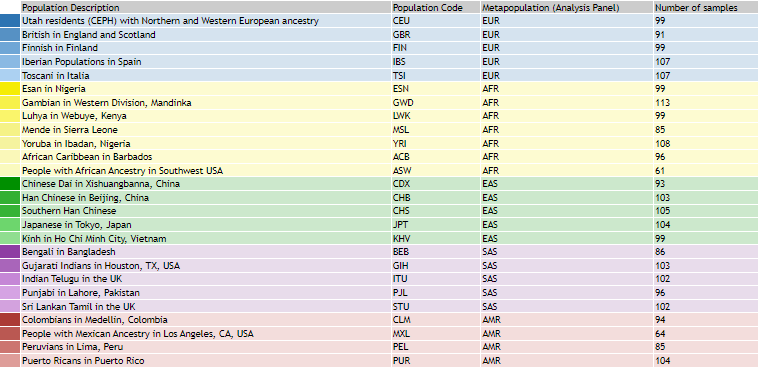

<img src="Images/R.png" alt="R" width="40"> Switch to the R kernel.

Let’s visualize population stratification using the multidimensional
scaling (MDS) results.

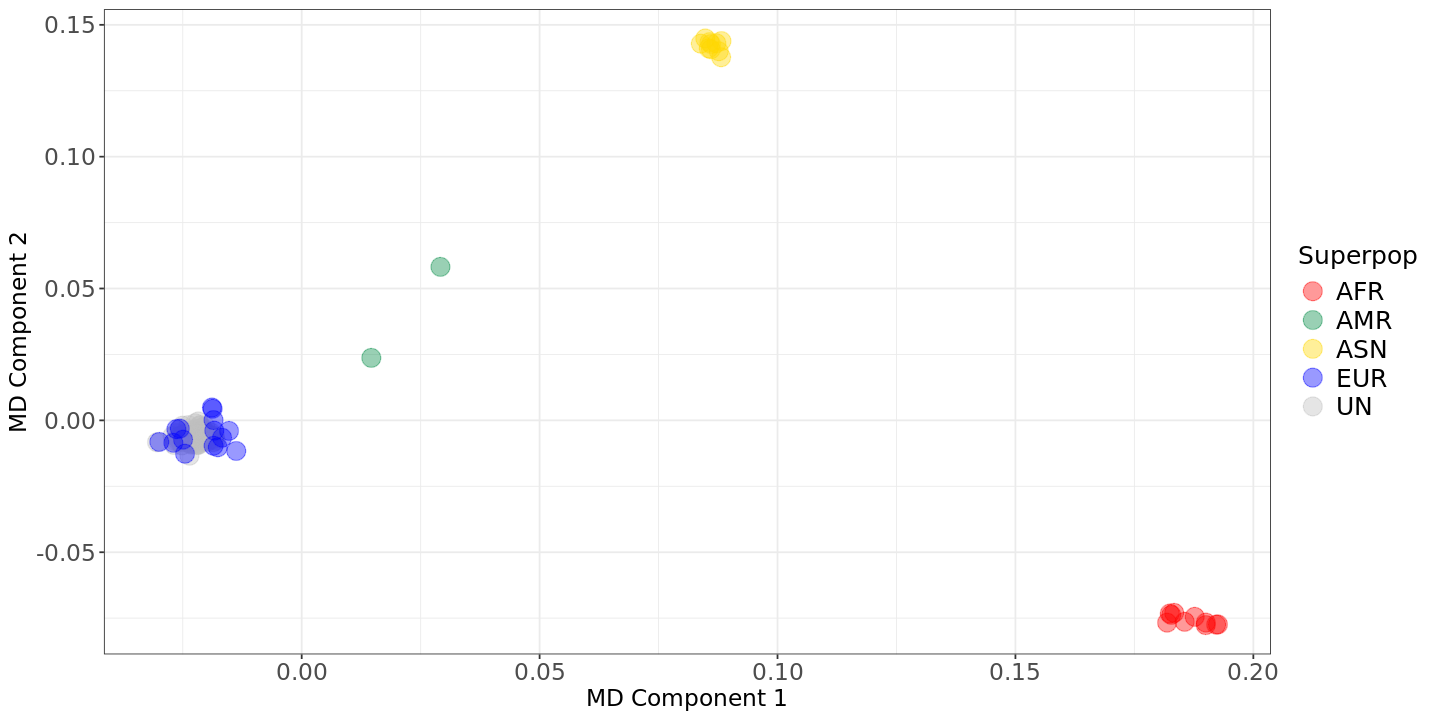

In [1]:
options(repr.plot.width = 12, repr.plot.height = 6)

suppressMessages(suppressWarnings(library(ggplot2)))

# Read data into R 
data <- read.table(file="Results/GWAS4/MDS_merge.mds",header=TRUE)
pop <- read.table(file="Results/GWAS4/popfile.txt",header=TRUE)
datafile <- merge(data,pop,by=c("FID","IID"))

# Metapopulation information for the population in the 1000GP dataset
superpop <- c(
  "JPT" = "ASN",
  "ASW" = "AFR",
  "CEU" = "EUR",
  "CHB" = "ASN",
  "CHD" = "ASN",
  "YRI" = "AFR",
  "LWK" = "AFR",
  "TSI" = "EUR",
  "MXL" = "AMR",
  "GBR" = "EUR",
  "FIN" = "EUR",
  "CHS" = "ASN",
  "PUR" = "AMR",
  "OWN" = "UN"
)

# add metapopulation info to the table 
datafile$SUPERPOP <- superpop[datafile$POP]

# Plotting                
scatter.mds <- ggplot(datafile, aes(x=C1, y=C2, color=SUPERPOP)) +
  geom_point(size=5, alpha=.4) +
  scale_color_manual(values=c("AFR" = "red", "AMR" = "springgreen4", "ASN" = "gold", "EUR" = "blue", "UN" = "grey" )) +
  xlab("MD Component 1") + 
  ylab("MD Component 2") +
  labs(color="Superpop") +
  theme_bw() +
  theme(axis.title = element_text(size = 14), legend.text = element_text(size = 15), 
        axis.text = element_text(size = 14), legend.title=element_text(size=15))
  
show(scatter.mds)

The HapMap data clusters closely with European populations such as CEU,
TSI, IBS, GBR, and FIN, confirming its European composition.
Additionally, the absence of distant points indicates no outliers in the
HapMap dataset (grey datapoints cluster together).

#### Exclude ethnic outliers

Now imagine we want to consider only European individuals for a specific
analysis where we want only such homogeneous population. Then the rest
of the individuals consists of outliers.

> **Stop - Read - Solve**
>
> **What values would you select or apply in this context, and why?**

> **Solution**
>
> Based on the position of the target population’s cluster in the MDS
> plot, we will exclude individuals with MDS component 1 values less
> than 0 and MDS component 2 values less than -0.05.
>
> <img src="Images/bash.png" alt="Bash" width="40"> Switch to the Bash
> kernel. Let’s see how the MDS table is structured:
>
> ``` bash
> head -3 Results/GWAS4/MDS_merge.mds | cut -f1-6 -d$'\t'
> ```
>
>         FID       IID    SOL           C1           C2           C3           C4           C5           C6           C7           C8           C9          C10 
>        1328   NA06984      0   -0.0220235  -0.00643748  -0.00383372   0.00144623  -0.00179491   0.00329767   0.00937787  -0.00709728  -0.00916042    0.0145214 
>        1328   NA06989      0   -0.0208739  -0.00562554  -0.00618303   0.00405602  0.000816232  -0.00392579    0.0125535    0.0268739    0.0353041   -0.0101189 
>
> The first three columns denote samples, while *C1, C2, …* are MDS
> components. We will select the individuals we want to keep based on
> coordinates *C1, C2*, so the area to be chosen has to be C1\<0 and
> C2\<0.05. Thus we take the values in columns 4 and 5 of the file , and
> extract the individuals using PLINK with the option `--keep`.
>
> ``` bash
> #print samples to keep in a file
> awk '{ if ($4 <0 && $5<0.05) print $1,$2 }' Results/GWAS4/MDS_merge.mds > Results/GWAS4/EUR_MDS_merge
>
> #use the keep --option
> plink --bfile Results/GWAS4/MDS_merge \
>     --keep Results/GWAS4/EUR_MDS_merge \
>     --make-bed  \
>     --out Results/GWAS4/EUR_MDS_merge
> ```
>
>     PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
>     (C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
>     Logging to Results/GWAS4/EUR_MDS_merge.log.
>     Options in effect:
>       --bfile Results/GWAS4/MDS_merge
>       --keep Results/GWAS4/EUR_MDS_merge
>       --make-bed
>       --out Results/GWAS4/EUR_MDS_merge
>
>     385567 MB RAM detected; reserving 192783 MB for main workspace.
>     376380 variants loaded from .bim file.
>     146 people (55 males, 54 females, 37 ambiguous) loaded from .fam.
>     Ambiguous sex IDs written to Results/GWAS4/EUR_MDS_merge.nosex .
>     109 phenotype values loaded from .fam.
>     --keep: 124 people remaining.
>     Using 1 thread (no multithreaded calculations invoked).
>     Before main variant filters, 124 founders and 0 nonfounders present.
>     Calculating allele frequencies... done.
>     Total genotyping rate in remaining samples is 0.99826.
>     376380 variants and 124 people pass filters and QC.
>     Among remaining phenotypes, 54 are cases and 55 are controls.  (15 phenotypes
>     are missing.)
>     --make-bed to Results/GWAS4/EUR_MDS_merge.bed + Results/GWAS4/EUR_MDS_merge.bim
>     + Results/GWAS4/EUR_MDS_merge.fam ... done.
>
> How many people are we left with? see the output message above or find
> the log file
>
> ``` bash
> grep "remaining" Results/GWAS4/EUR_MDS_merge.log
> ```
>
> <pre>--keep: 124 people <span class="ansi-red-fg ansi-bold">remaining</span>.
>
> Total genotyping rate in <span class="ansi-red-fg ansi-bold">remaining</span> samples is 0.99826.
>
> Among <span class="ansi-red-fg ansi-bold">remaining</span> phenotypes, 54 are cases and 55 are controls.  (15 phenotypes
> </pre>

------------------------------------------------------------------------

#### Creating covariates for GWAS analysis

The 10 MDS dimensions will be used as covariates in the association
analysis in the next tutorial to correct for population stratification.
The covariate file is created by removing column 3 (`SOL`, optional
metadata) from the MDS output file.

> **Stop - Read - Solve**
>
> **Why are we computing the covariates again?**

> **Solution**
>
> The data has been filtered, and the remaining samples will have a very
> tight MDS structure, since they were projected in relationship to
> other very different samples. Now we might want to capture some
> substructure in the CEU population instead.

This time we will not use MDS projection, but the PCA implemented in
PLINK2. In our dataset this will not change much (actually it might be a
bit slower, because it also recalculates the relatedness matrix and
normalizes it), but for large datasets PCA is faster, and you can also
use an approximated PCA which is even faster on many thousands of
samples ([all details here in the
manual](https://www.cog-genomics.org/plink/2.0/strat)). The default is
to calculate ten components, but you can for example choose more as we
fo here. `biallelic-var-wts` ensures PLINK2 does not apply its own
filtering to our data.

In [4]:
plink2 --bfile Results/GWAS4/EUR_MDS_merge \
    --pca 20 biallelic-var-wts \
    --out Results/GWAS4/EUR_MDS_merge

PLINK v2.00a5.12LM 64-bit Intel (25 Jun 2024)  www.cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS4/EUR_MDS_merge.log.
Options in effect:
  --bfile Results/GWAS4/EUR_MDS_merge
  --out Results/GWAS4/EUR_MDS_merge
  --pca 20 biallelic-var-wts

Start time: Tue Apr  1 10:22:19 2025
385567 MiB RAM detected, ~357174 available; reserving 192783 MiB for main
workspace.
Using up to 64 threads (change this with --threads).
124 samples (54 females, 55 males, 15 ambiguous; 124 founders) loaded from
Results/GWAS4/EUR_MDS_merge.fam.
376380 variants loaded from Results/GWAS4/EUR_MDS_merge.bim.
1 binary phenotype loaded (54 cases, 55 controls).
Calculating allele frequencies... done.
Constructing GRM: done.
Correcting for missingness... done.
Extracting eigenvalues and eigenvectors... done.
--pca: Variant weights written to Results/GWAS4/EUR_MDS_merge.eigenvec.var .
--pca: Eigenvectors written to Results/GWAS4/EUR_MDS_m

The output file looks like this, where the PCA components start from the
third columns

In [5]:
head Results/GWAS4/EUR_MDS_merge.eigenvec

#FID    IID PC1 PC2 PC3 PC4 PC5 PC6 PC7 PC8 PC9 PC10    PC11    PC12    PC13    PC14    PC15    PC16    PC17    PC18    PC19    PC20
1328    NA06984 -0.00859205 -0.000713344    0.0019488   -0.0194148  0.00557532  -0.00846987 -0.114078   -0.0171505  -0.0438258  -0.107577   0.104002    -0.055593   0.0736573   -0.0135244  -0.0364878  0.00538918  -0.109144   -0.059361   -0.00440937 -0.0431937
1328    NA06989 -0.0136658  -0.0149942  0.00301289  -0.0254053  0.272088    0.00254102  0.144933    0.119846    0.0886107   0.0638438   -0.0630205  0.0356998   -0.0759603  -0.0370554  -0.0418473  0.0527318   -0.0121366  0.0479597   -0.0367867  -0.0305699
1330    NA12340 -0.00616811 -0.00485281 -0.000446531    -0.020636   -0.0307426  0.0758664   0.0131584   0.0281449   -0.0210886  -0.0258555  -0.00743298 -0.00302273 -0.0698325  0.0820405   0.0920026   0.11563 -0.0247229  0.0971549   0.246957    -0.0211716
1330    NA12341 0.00463878  0.00140834  0.011076    -0.023228   -0.0811037  0.0163619   -0.0024816

<img src="Images/R.png" alt="Bash" width="40"> Switch to the R kernel.
Let’s print the PCA again.

In [2]:
library(ggplot2)
library(data.table)  # For fast data reading

# Load the PCA eigenvector file
pca_data <- fread("Results/GWAS4/EUR_MDS_merge.eigenvec", header = TRUE)

# Preview the data
head(pca_data)
dim(pca_data)

124 22

We can see some substructure, where most individuals are tightly
clustered together.

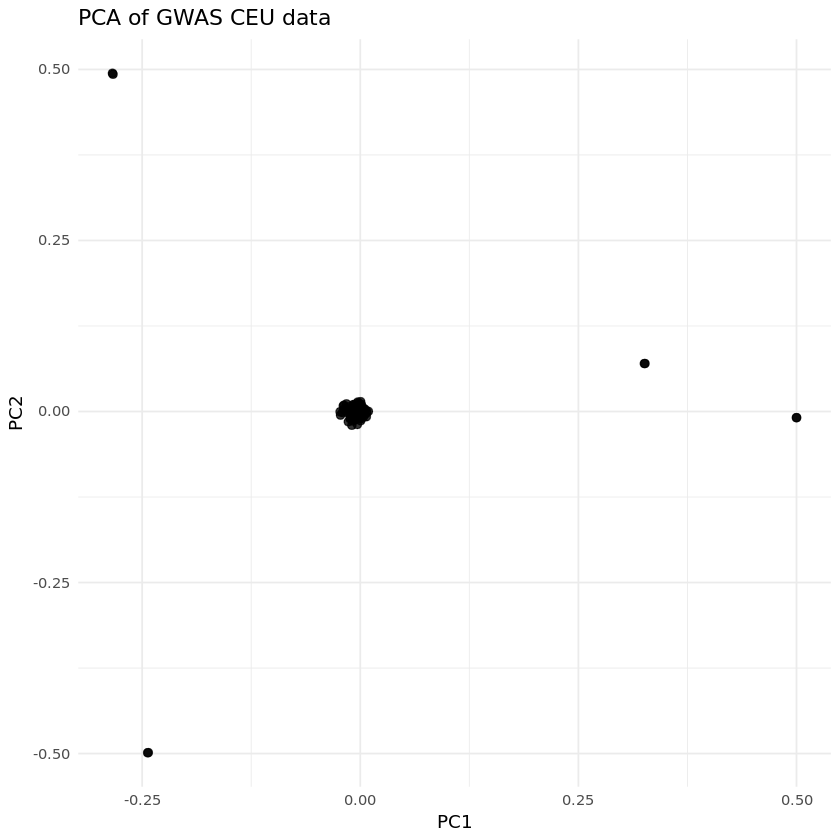

In [5]:
ggplot(pca_data, aes(x = PC1, y = PC2)) +
  geom_point(size = 2, alpha = 0.8) +
  labs(title = "PCA of GWAS CEU data",
       x = "PC1",
       y = "PC2") +
  theme_minimal() +
  theme(legend.position = "right")


To make the file usable as a covariate we remove the very first
character \# from the column name of the PCA output:

In [1]:
sed 's/^#//' Results/GWAS4/EUR_MDS_merge.eigenvec > Results/GWAS4/covar_pca.txt

The `covar_pca.txt` now looks like this

In [2]:
head -5 Results/GWAS4/covar_pca.txt

FID IID PC1 PC2 PC3 PC4 PC5 PC6 PC7 PC8 PC9 PC10    PC11    PC12    PC13    PC14    PC15    PC16    PC17    PC18    PC19    PC20
1328    NA06984 -0.00859205 -0.000713344    0.0019488   -0.0194148  0.00557532  -0.00846987 -0.114078   -0.0171505  -0.0438258  -0.107577   0.104002    -0.055593   0.0736573   -0.0135244  -0.0364878  0.00538918  -0.109144   -0.059361   -0.00440937 -0.0431937
1328    NA06989 -0.0136658  -0.0149942  0.00301289  -0.0254053  0.272088    0.00254102  0.144933    0.119846    0.0886107   0.0638438   -0.0630205  0.0356998   -0.0759603  -0.0370554  -0.0418473  0.0527318   -0.0121366  0.0479597   -0.0367867  -0.0305699
1330    NA12340 -0.00616811 -0.00485281 -0.000446531    -0.020636   -0.0307426  0.0758664   0.0131584   0.0281449   -0.0210886  -0.0258555  -0.00743298 -0.00302273 -0.0698325  0.0820405   0.0920026   0.11563 -0.0247229  0.0971549   0.246957    -0.0211716
1330    NA12341 0.00463878  0.00140834  0.011076    -0.023228   -0.0811037  0.0163619   -0.00248169 0.

instead of

In [4]:
head -5 Results/GWAS4/EUR_MDS_merge.eigenvec

#FID    IID PC1 PC2 PC3 PC4 PC5 PC6 PC7 PC8 PC9 PC10    PC11    PC12    PC13    PC14    PC15    PC16    PC17    PC18    PC19    PC20
1328    NA06984 -0.00859205 -0.000713344    0.0019488   -0.0194148  0.00557532  -0.00846987 -0.114078   -0.0171505  -0.0438258  -0.107577   0.104002    -0.055593   0.0736573   -0.0135244  -0.0364878  0.00538918  -0.109144   -0.059361   -0.00440937 -0.0431937
1328    NA06989 -0.0136658  -0.0149942  0.00301289  -0.0254053  0.272088    0.00254102  0.144933    0.119846    0.0886107   0.0638438   -0.0630205  0.0356998   -0.0759603  -0.0370554  -0.0418473  0.0527318   -0.0121366  0.0479597   -0.0367867  -0.0305699
1330    NA12340 -0.00616811 -0.00485281 -0.000446531    -0.020636   -0.0307426  0.0758664   0.0131584   0.0281449   -0.0210886  -0.0258555  -0.00743298 -0.00302273 -0.0698325  0.0820405   0.0920026   0.11563 -0.0247229  0.0971549   0.246957    -0.0211716
1330    NA12341 0.00463878  0.00140834  0.011076    -0.023228   -0.0811037  0.0163619   -0.0024816

> **Wrapping up**
>
> You have now successfully checked your data for relatedness population
> stratification. You filtered out the individuals with high relatedness
> and produced a summary of the population structure using the MDS
> projection. You will use the MDS coordinates as a proxy for the
> population structure you want your association testing to be corrected
> for.
>
> In the next notebook on **Association Testing**, you will need the
> following files from the folder `Results/GWAS4/`: - `EUR_MDS_merge`
> PLINK file set - `covar_pca.txt`
>
> which are the HapMap data and the MDS covariates highlighting the
> population stratification inside the european cluster. Those are
> already available once you have been running this notebook.
>
> Below is a cheat sheet of our new methods of QC.
>
> | Step | Command | Function | Thresholds and explanation |
> |----|----|-----------------------|------------------------------------------|
> | 7: Population Stratification | `--cluster --mds-plot k` (PLINK) | Produces a k‐dimensional representation of any substructure in the data, based on IBS. | K is the number of dimensions, which needs to be defined (typically 10). This is an important step of the QC that consists of multiple proceedings but for reasons of completeness, we briefly refer to this step in the table. This step will be described in more detail in the section “Controlling for population stratification.” |
> | \- | `--pca k biallelic-var-wts` (PLINK2) | produces a PCA projection with `k` principal components, based on the normalized genetic relationship matrix. `biallelic-var-wts` ensures that PLINK2’s own filtering is not applied. | \- |

# Bibliography

Abdellaoui, Abdel, Jouke-Jan Hottenga, Peter de Knijff, Michel G Nivard,
Xiangjun Xiao, Paul Scheet, Andrew Brooks, et al. 2013. “Population
Structure, Migration, and Diversifying Selection in the Netherlands.”
*European Journal of Human Genetics* 21 (11): 1277–85.

Cortellari, Matteo, Mario Barbato, Andrea Talenti, Arianna Bionda,
Antonello Carta, Roberta Ciampolini, Elena Ciani, et al. 2021. “The
Climatic and Genetic Heritage of Italian Goat Breeds with Genomic SNP
Data.” *Scientific Reports* 11 (1): 10986.
<https://doi.org/10.1038/s41598-021-89900-2>.

Price, Alkes L., Nick J. Patterson, Robert M. Plenge, Michael E.
Weinblatt, Nancy A. Shadick, and David Reich. 2006. “Principal
Components Analysis Corrects for Stratification in Genome-Wide
Association Studies.” *Nature Genetics* 38 (8): 904–9.
<https://doi.org/10.1038/ng1847>.

Price, Alkes L, Noah A Zaitlen, David Reich, and Nick Patterson. 2010.
“New Approaches to Population Stratification in Genome-Wide Association
Studies.” *Nature Reviews Genetics* 11 (7): 459–63.

Rietveld, Cornelius A, Sarah E Medland, Jaime Derringer, Jian Yang, Tõnu
Esko, Nicolas W Martin, Harm-Jan Westra, et al. 2013. “GWAS of 126,559
Individuals Identifies Genetic Variants Associated with Educational
Attainment.” *Science* 340 (6139): 1467–71.

Somers, Metten, Loes M. Olde Loohuis, Maartje F. Aukes, Bogdan Pasaniuc,
Kees C. L. De Visser, René S. Kahn, Iris E. Sommer, and Roel A. Ophoff.
2017. “A Genetic Population Isolate in The Netherlands Showing Extensive
Haplotype Sharing and Long Regions of Homozygosity.” *Genes* 8 (5): 133.
<https://doi.org/10.3390/genes8050133>.